<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview: The code below is for the purpose of comparing the quality of the algorithms Lsa, KL, LexRank, TextRank, SumBasic, Luhn with the model I trained**

# **Connect to drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Install lib**

In [3]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.6 MB/s eta 0:00:00
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645932 sha256=a3bd1437f3394f2993cf34fb8f5ec7cd103b936c51cff598ffcb882feb85260e
  Stored in directory: /root/.cache/pip/wheels/5d/d9/b3/41f6c6b1ab758561fd4aab55dc0480b9d7a131c6aaa573a3fa
Successfully built vncorenlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━

In [4]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=5536a6956c4e9d4bcc6ae75ce09047e2c92aa13991a5b3556ac7db795130188f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [5]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [6]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
!pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=6360399792af2b35a96aae3faf2d23888bcc3d9ed6538f2e29a43f52639feec6
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=2271d5ea595e17baf4f54f2950e5da01abbd26aa43ac345c55b042b620927632
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=1068

# **Processing data**

In [8]:
size_data_test = 10
summary_task_original_new = []

In [9]:
# Đọc danh sách các file từ đường dẫn được cung cấp
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == size_data_test:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/*.txt')
for file in test_paths:
  print(file)

/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/02.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/04.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/10.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/11.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/13.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/14.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/15.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/19.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/03.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/08.txt


In [10]:
# Đọc nội dung file
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """
  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""
  summary_taskDict = []
  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      # print("\n\n path_file:",path_file)
      # print("\n\n lines:",lines)
      for line in lines:
          line = line.strip()

          if "NOI_DUNG_TOM_TAT" in line:
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif "NHIEM_VU" in line:#line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          # new code
          elif "NGUOI_LAM" in line: #line.startswith("NGUOI_LAM"):
              summary_taskDict.append({ "people": "", "content": "", "time": ""})
              cnt = 20
              line = line.replace("NGUOI_LAM", "")
              line = line.replace(":", "")
          elif "NOI_DUNG_CV" in line: #line.startswith("NOI_DUNG_CV"):
              cnt = 21
              line = line.replace("NOI_DUNG_CV", "")
              line = line.replace(":", "")
          elif "THOI_GIAN" in line: #line.startswith("THOI_GIAN"):
              cnt = 22
              line = line.replace("THOI_GIAN", "")
              line = line.replace(":", "")
          #end
          elif "NOI_DUNG_GOC" in line: #line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")

          line += " "
          # line  = line.replace("..", ". ")
          if line:
            if cnt == 1:
              summary_content += line
            #elif cnt == 2:
            #  summary_task += line
            elif cnt == 20:
              summary_taskDict[-1]["people"] += line
            elif cnt == 21:
              summary_taskDict[-1]["content"] += line
            elif cnt == 22:
              summary_taskDict[-1]["time"] += line

            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  summary_task_original_new.append({'file' : path_file,
          'summary_task': summary_taskDict})

  return {'file' : path_file,
          # 'summary_task': summary_taskDict,
          'summary_content': summary_content,
          'original': original}

In [11]:
# Đọc các key word
def get_stop_words_vn(path):
    ret = []
    # path = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
time_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-time.txt")
print("time_words", time_words)
print("task_words", task_words)

time_words [' deadline ']
task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ', ' đảm nhận ']


## **Get data**

In [12]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [13]:

test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_content"] )

summary_task_original_new = []
for path_file in test_df["file"]:
  read_content(path_file)

for task in summary_task_original_new:
  print ("task", task )

test_df 0    ﻿ Vào hồi 16 giờ ngày 22 tháng 8 năm 2021  diễ...
1     ban chi uỷ chi bộ Minh Dương tổ chức cuộc   h...
2     Gia đình Tuyến tổ chức cuộc họp nhằm tìm các ...
3     Trong cuộc họp giao nhiệm vụ của công ty Vạn ...
4    ﻿ Lớp 11A3 tổ chức cuộc họp năm khen thưởng độ...
5    ﻿ Cuộc họp diễn ra tại công ty Vạn Thắng nhằm ...
6     Ban chỉ đạo trường THCS Hồng Thái họp bàn về ...
7     Gia đình ông Nguyễn Văn Tùng tổ chức cuộc họp...
8     Vào 7 giờ 15 phút ngày 24 tháng 6 năm 2023 , ...
9     Công ty Nam Khánh  diễn ra cuộc họp quan trọn...
Name: summary_content, dtype: object
task {'file': '/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/11.txt', 'summary_task': [{'people': ' Lan ', 'content': ' đảm nhận đánh giá trong tháng 8 của ban BCH công đoàn và triển khai nhiệm vụ tháng 9 của UBKT ', 'time': ' Deadline 22 tháng 8, 2021  '}, {'people': ' Hương ', 'content': ' đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của CĐCS ', 'time': ' Deadline 22 tháng

In [14]:
test_data =  Dataset.from_pandas(test_df)

In [15]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

## **Summary task**

### **Case 1: Using vnvorenlp**



In [16]:
!pip install vncorenlp

In [17]:
import os
from vncorenlp import VnCoreNLP
vncorenlp_folder = '/content/drive/MyDrive/LLM_TEXT/VnCoreNLP-master/'
vncorenlp_file = os.path.join(vncorenlp_folder, 'VnCoreNLP-1.1.1.jar')

vnlp = VnCoreNLP(vncorenlp_file, annotators="wseg,pos,ner")

In [18]:
text = "Hôm nay ngày 21 tháng 4 năm 2023 tại trường THCS kim Liên diễn ra cuộcHôm nay, Mai Anh và Hải Đăng đã đến thăm chị Lan tại Hà Nội. họp của ban trung tâm bàn nội "
def getName(str):
  annotated_text = vnlp.annotate(str)
  person_entities = []
  for sentence in annotated_text['sentences']:
      for entity in sentence:
          if entity["nerLabel"] == 'B-PER':
              person_entities.append(entity["form"])
  return person_entities

print(getName(text))

['Mai_Anh', 'Hải_Đăng', 'Lan']


### **Case 2: Pre-train model (PhoBERT)**

In [19]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizerName = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

modelName = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/trainning_Name/checkpoint-8000')
modelName.to("cpu")
batch_size = 32  # change to 64 for full evaluation



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [20]:
# map data correctly
def getNameCase2(strInput):
    ret = []
    inputs = tokenizerName(strInput, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu") #cuda
    attention_mask = inputs.attention_mask.to("cpu")
    outputs = modelName.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizerName.batch_decode(outputs, skip_special_tokens=True)
    for name in output_str:
      if name in strInput:
        ret.append(name)
    return ret

### **Summary Task**

In [21]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import re

def contains_digits(input_str):
    digit_pattern = r'\d'
    match = re.search(digit_pattern, input_str)
    return match is not None

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str, case1 = True):
  sentences = process_content_sentences(str, 1, 400)
  ret = []
  for sentence in sentences:
    sentencelower = sentence.lower()
    time = ""
    for wTime in time_words:
      if wTime.strip() in sentencelower:
          time = sentencelower
          try:
            if contains_digits(time):
              ret[-1]["time"] = time
              # print("time ", time)
          except:
            pass

          break
    for wTask in task_words:
      if wTask.strip() in sentencelower:
        people = []
        if case1:
          people = getName(sentence)
        else:
          people = getNameCase2(sentence)

        ret.append({"people": people, "content": sentencelower, "time": "" })
        break
  return ret

In [22]:

# txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/05.txt")
# print ("Nội dung gốc: ", txt['original'])
# test_task = detectTask(txt['original'], False)
# cnt_32 = 0
# for task in test_task:
#   cnt_32 += 1
#   print("\n")
#   print ("Nhiệm vụ thứ ", cnt_32)
#   print("Người làm: ", task['people'])
#   print("Nội dung nhiệm vụ: ", task['content'])
#   print("thời gian: ", task['time'])

# **Inference**

In [23]:
path_result = "/content/drive/MyDrive/LLM_TEXT/inference/infer_BBCH/"
RATIO = 0.2
listAlorithms = ['KLSummarizer','LexRankSummarizer','LsaSummarizer','LuhnSummarizer','SumBasicSummarizer','TextRankSummarizer']
models = listAlorithms
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
rougel_recall = []
rougel_precision = []
rougel_f1 = []

In [24]:
def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

## **With my model**

In [25]:
myModelName = 'Custom "Custom PhoBERT"'

In [26]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/training/checkpoint-30000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [27]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]

print ("result_summary_content: ",result_summary_content[0] )
print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
print ("original: ",test_data[0]["original"] )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  DeadDeadline đưa ra nhận_định sau khi nghe tin_tức về vụ ám_sát nhà_báo Minh Khai. Theo đó, đây sẽ là một năm đầy biến_động.
file:  /content/drive/MyDrive/LLM_TEXT/dataset/BBCH/11.txt
summary_conten:  ﻿ Vào hồi 16 giờ ngày 22 tháng 8 năm 2021  diễn ra cuộc họp của  ban chấp hành công đoàn trường TH Minh Khai định kỳ  nhằm đánh giá hoạt động của UBKT tháng 8 năm 2021 và triển khai kế hoạch hoạt động của UBKT tháng 9 năm 2021  . Bà Nguyễn Mai Lan chủ tịch công đoàn là chủ tọa điều hành cuộc họp.  
original:   Hôm nay vào hồi 16 giờ ngày 22 tháng 8 năm 2021  diễn ra cuộc họp của  ban chấp hành công đoàn trường TH Minh Khai định kỳ  nhằm đánh giá hoạt động của UBKT tháng 8 năm 2021 và triển khai kế hoạch hoạt động của UBKT tháng 9 năm 2021. BCH công đoàn gồm 4 thành viên : Lan, Hương, Mạnh. Kiên. Lan chủ tịch công đoàn là chủ tọa  điều hành cuộc họp và phân công nhiệm vụ cụ thể  cho các thành viên. Lan đảm nhận đánh giá trong tháng 8 của ban BCH công đoàn và triển 

In [28]:
# Trích xuất nhiệm vụ từ văn bản cuộc họp, sử dụng mô hình Vncorenlp
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data, True)
  result_summary_task.append(ret_task)
  for task in ret_task:
    print ("task", task)

task {'people': ['Lan'], 'content': 'lan chủ tịch công đoàn là chủ tọa  điều hành cuộc họp và phân công nhiệm vụ cụ thể  cho các thành viên.', 'time': ''}
task {'people': ['Lan'], 'content': 'lan đảm nhận đánh giá trong tháng 8 của ban bch công đoàn và triển khai nhiệm vụ tháng 9 của ubkt.', 'time': 'deadline 22 tháng 8, 2021.'}
task {'people': ['Hương'], 'content': 'hương đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của cđcs.', 'time': 'deadline 22 tháng 9, 2021.'}
task {'people': [], 'content': 'mạnh đảm nhận xây dựng kế hoạch cho ngày kỉ niệm 76 quốc khánh nước cộng hoà xã hội chủ nghĩa việt nam.', 'time': 'deadline 2 tháng 9, 2021.'}
task {'people': ['Kiên', 'Lan', 'Hương'], 'content': 'kiên  đảm nhận kết hợp với các đồng chí lan, và hương thực hiện tốt nhiệm vụ được phân công.', 'time': 'deadline 20 tháng 9, 2021.'}
task {'people': [], 'content': 'thời gian để cả tổ hoàn thành các nhiệm vụ bắt đầu từ hôm nay, ngày 22 tháng 8 năm 2021 đến ngày 20 tháng 

In [29]:
# Trích xuất nhiệm vụ từ văn bản cuộc họp, sử dụng model "Custom PhoBERT"
result_summary_task_new = []
for data in test_df["original"]:
  ret_task = detectTask(data, False)
  result_summary_task_new.append(ret_task)
  for task in ret_task:
    print ("task", task)

task {'people': [], 'content': 'lan chủ tịch công đoàn là chủ tọa  điều hành cuộc họp và phân công nhiệm vụ cụ thể  cho các thành viên.', 'time': ''}
task {'people': ['Lan'], 'content': 'lan đảm nhận đánh giá trong tháng 8 của ban bch công đoàn và triển khai nhiệm vụ tháng 9 của ubkt.', 'time': 'deadline 22 tháng 8, 2021.'}
task {'people': ['Hương'], 'content': 'hương đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của cđcs.', 'time': 'deadline 22 tháng 9, 2021.'}
task {'people': ['Mạnh'], 'content': 'mạnh đảm nhận xây dựng kế hoạch cho ngày kỉ niệm 76 quốc khánh nước cộng hoà xã hội chủ nghĩa việt nam.', 'time': 'deadline 2 tháng 9, 2021.'}
task {'people': [], 'content': 'kiên  đảm nhận kết hợp với các đồng chí lan, và hương thực hiện tốt nhiệm vụ được phân công.', 'time': 'deadline 20 tháng 9, 2021.'}
task {'people': [], 'content': 'thời gian để cả tổ hoàn thành các nhiệm vụ bắt đầu từ hôm nay, ngày 22 tháng 8 năm 2021 đến ngày 20 tháng 9 năm 2021.', 'time':

## **Inference data with algorithms** [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]

In [30]:
import os
import re

def write_data(folder, offset, index, content):
  path = folder+"/summary_{:06d}.txt".format(offset+index+1)
  f = open(path, "w")
  f.write(content)
  f.close()

def folderExist(folder_path):
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

def clean_text(text):
  text = text.replace("\n"," ")
  text = re.sub("\s\s+"," ",text)
  text = text.replace("TP.", "TP")
  text = re.sub("\.\.+",".",text)
  text = re.sub("…",".",text)
  all_number = re.findall("\d*\.\d+",text)
  all_dot = re.findall("[A-Z|Ê|Ư|Ơ|Â|Ă|Đ]\s*\.", text)
  text_dot = re.findall("\.\s+[^A-Z|Ê|Ư|Ơ|Â|Ă|Đ]", text)
  for w in all_number:
    text = text.replace(w, w.replace(".",""))
  for w in all_dot:
    text = text.replace(w, w.replace(".",""))
  for w in text_dot:
    text = text.replace(w, w.replace(".",""))
  text = re.sub(r"[()\"#@:<>{}`+=~|!“”]", "", text)
  print("allnumber:",all_number)
  print("all_dot",all_dot)
  print('text_dot:',text_dot)
  return text

def load_sum(model, content, index):
  name_model = str(type(model)).split(".")[-1].replace("'>","")
  result = ''
  path = path_result + name_model
  folderExist(path)
  lenght = len(parser.document.sentences)
  count = 1 if RATIO * lenght < 1 else lenght * RATIO
  for sentence in model(content, count):
      result += str(sentence) + " "
  write_data(path, 0, idx, result)

In [31]:
class TokenizerVNVal:
    @staticmethod
    def to_sentences(text: str):
        return [s.strip() for s in text.split(".")]
    @staticmethod
    def to_words(sentence: str):
        # sentence = sentence.replace("_", " ")
        return [w.strip() for w in sentence.split(" ")]

In [32]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.utils import get_stop_words
import nltk


path_file_stopword = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
# print(test_df)
if __name__ == "__main__":

    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    # parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
    lsaSummarizer = LsaSummarizer()
    lsaSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    kLSummarizer = KLSummarizer()
    kLSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    lexRankSummarizer = LexRankSummarizer()
    lexRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    luhnSummarizer = LuhnSummarizer()
    luhnSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    textRankSummarizer = TextRankSummarizer()
    textRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    sumBasicSummarizer = SumBasicSummarizer()
    sumBasicSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    for idx, originnalTxt in enumerate(test_df["original"]):
        print(idx)
        parser = PlaintextParser.from_string(clean_text(originnalTxt), TokenizerVNVal)
        load_sum(lsaSummarizer, parser.document, idx)
        load_sum(kLSummarizer, parser.document, idx)
        load_sum(lexRankSummarizer, parser.document, idx)
        load_sum(textRankSummarizer, parser.document, idx)
        load_sum(luhnSummarizer, parser.document, idx)
        load_sum(sumBasicSummarizer, parser.document, idx)


0
allnumber: []
all_dot ['T.', 'S.']
text_dot: ['. .']
1
allnumber: []
all_dot []
text_dot: ['. Ô', '. Ô', '. Ô', '. Ô']
2
allnumber: []
all_dot []
text_dot: []
3
allnumber: []
all_dot []
text_dot: []
4
allnumber: []
all_dot []
text_dot: []
5
allnumber: []
all_dot []
text_dot: []
6
allnumber: []
all_dot []
text_dot: []
7
allnumber: []
all_dot []
text_dot: []
8
allnumber: []
all_dot []
text_dot: []
9
allnumber: []
all_dot []
text_dot: []


In [33]:
from sumy.parsers.plaintext import PlaintextParser
from statistics import mean, median

def get_data_evalue(folder, offset, count):
  data = []
  for i in range(count):
    path = folder + "/summary_{:06d}.txt".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    for line in lines:
        sum += line.replace("_"," ") + " "
    sum = sum.replace("\n","")
    sum = sum.replace("<q>"," ")
    sum = sum.lower()
    data.append(sum)
  return data

def evalue(model):
    path_sum = path_result +"/" +  model
    data_sum = get_data_evalue(path_sum, 0, size_data_test)
    r1_recall = []
    r1_precision = []
    r1_f = []

    r2_recall= []
    r2_precision = []
    r2_f = []
    rl_sent = []
    rl_sum = []

    print("model: ", model)
    ret_rouge_ = rouge.compute(predictions=data_sum, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
    # for key,value in ret_rouge_.items():
    #   print(key)
    #   print(value.mid)

    getRougeMyModel(ret_rouge_)

In [34]:
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
models = listAlorithms
for model in models:
  if model != myModelName:
    evalue(model)


# getRougeMyModel()


model:  KLSummarizer
rouge1:recall 0.5477186743821161 -precision 0.6122983794488484 -F1-Score 0.5347923057844245
rouge2:recall 0.2608084889461316 -precision 0.2640178226651064 -F1-Score 0.24541991394285473
rougeL:recall 0.3855881334487129 -precision 0.42285818543491177 -F1-Score 0.37384863932236
model:  LexRankSummarizer
rouge1:recall 0.4726263307684767 -precision 0.817759804528773 -F1-Score 0.5648819106427294
rouge2:recall 0.315175223022373 -precision 0.5629157860348698 -F1-Score 0.3814505031626635
rougeL:recall 0.358669781226714 -precision 0.64904846605827 -F1-Score 0.43957775429383883
model:  LsaSummarizer
rouge1:recall 0.49870858739258406 -precision 0.7485223317618884 -F1-Score 0.563672929190931
rouge2:recall 0.2519603406644886 -precision 0.4417300992528047 -F1-Score 0.2999140190495667
rougeL:recall 0.349332393906016 -precision 0.561513981818756 -F1-Score 0.40556066687237924
model:  LuhnSummarizer
rouge1:recall 0.43007533213349125 -precision 0.8537765660186803 -F1-Score 0.541667736

# **Evaluation**


## **Evaluation summary content**

In [35]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
models.append(myModelName)
getRougeMyModel(rouge_summary_content)


Evaluation content
rouge1:recall 0.6281361913772995 -precision 0.4016641406965362 -F1-Score 0.45048413764809425
rouge2:recall 0.18248389207691532 -precision 0.11927319620837387 -F1-Score 0.13698981157830625
rougeL:recall 0.3840429882998283 -precision 0.2547327053294658 -F1-Score 0.2816572402181979


## **Evaluation summary task**

In [36]:
# Đánh giá việc trích xuất nhiệm vụ theo phương pháp sử dụng Vncorenlp
summary_task_originnal_people = []
summary_task_originnal_content = []
summary_task_originnal_time = []

summary_task_result_people = []
summary_task_result_content = []
summary_task_result_time = []
cnt_1 = 0
print("summary_task_original_new ", len(summary_task_original_new))
print("result_summary_task ", len(result_summary_task))
for task_original in summary_task_original_new:
  p_o = ""
  c_o = ""
  t_o = ""

  p_r = ""
  c_r = ""
  t_r = ""

  for oriTask in task_original['summary_task']:
    if oriTask['people']:
      p_o += ". " + oriTask['people']
    if oriTask['content']:
      c_o += ". " + oriTask['content']
    if oriTask['time']:
      t_o += ". " + oriTask['time']


  for retTask in result_summary_task[cnt_1]:
    listPeople = retTask['people']
    if listPeople:
      for poe in listPeople:
        p_r += ". " + poe
    if retTask['content']:
      c_r += ". " + retTask['content']
    if retTask['time']:
      t_r += ". " + retTask['time']

  words = [word.strip() for word in p_o.split(".") if word.strip()]
  sorted_words = sorted(words, key=lambda x: x.lower())
  p_o = "." + ".".join(sorted_words)


  print ("p_o", p_o)
  print ("c_o", c_o)
  print ("t_o", t_o)

  words = [word.strip() for word in p_r.split(".") if word.strip()]
  sorted_words = sorted(words, key=lambda x: x.lower())
  p_r = "." + ".".join(sorted_words)

  print ("p_r", p_r)
  print ("c_r", c_r)
  print ("t_r", t_r)
  summary_task_originnal_people.append(p_o)
  summary_task_result_people.append(p_r)

  summary_task_originnal_content.append(c_o)
  summary_task_result_content.append(c_r)

  summary_task_originnal_time.append(t_o)
  summary_task_result_time.append(t_r)
  cnt_1 += 1
  print("\n")


summary_task_original_new  10
result_summary_task  10
p_o .Hương.Kiên.Lan.Mạnh
c_o .  đảm nhận đánh giá trong tháng 8 của ban BCH công đoàn và triển khai nhiệm vụ tháng 9 của UBKT .  đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của CĐCS .  đảm nhận xây dựng kế hoạch cho ngày kỉ niệm 76 Quốc khánh nước cộng hoà xã hội chủ nghĩa Việt Nam .  đảm nhận kết hợp với các đồng chí Lan, và Hương thực hiện tốt nhiệm vụ được phân công 
t_o .  Deadline 22 tháng 8, 2021  .  Deadline 22 tháng 9, 2021  .  Deadline 2 tháng 9, 2021  .  Deadline 20 tháng 9, 2021   
p_r .Hương.Hương.Kiên.Lan.Lan.Lan
c_r . lan chủ tịch công đoàn là chủ tọa  điều hành cuộc họp và phân công nhiệm vụ cụ thể  cho các thành viên.. lan đảm nhận đánh giá trong tháng 8 của ban bch công đoàn và triển khai nhiệm vụ tháng 9 của ubkt.. hương đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của cđcs.. mạnh đảm nhận xây dựng kế hoạch cho ngày kỉ niệm 76 quốc khánh nước cộng hoà xã hộ

In [39]:
# Đánh gái việc trích xuất nhiệm vụ theo phương pháp sử dụng "Custom PhoBERT"
summary_task_result_people_new = []
cnt_1 = 0
print("summary_task_original_new ", len(summary_task_original_new))
print("result_summary_task ", len(result_summary_task))
for task_original in summary_task_original_new:
  p_r = ""
  c_r = ""
  t_r = ""

  for retTask in result_summary_task_new[cnt_1]:
    listPeople = retTask['people']
    if listPeople:
      for poe in listPeople:
        p_r += ". " + poe
    if retTask['content']:
      c_r += ". " + retTask['content']
    if retTask['time']:
      t_r += ". " + retTask['time']

  words = [word.strip() for word in p_r.split(".") if word.strip()]
  sorted_words = sorted(words, key=lambda x: x.lower())
  p_r = "." + ".".join(sorted_words)
  print ("p_r", p_r)

  summary_task_result_people_new.append(p_r)
  cnt_1 += 1
  print("\n")

summary_task_original_new  10
result_summary_task  10
p_r .Hương.Lan.Mạnh


p_r .Hùng.Hải.Sơn


p_r .Hùng.Hùng.Hồng.Trung.Tuyến


p_r .Anh.Dương.Linh.Ngọc.Phương.Phương


p_r .Cường.Nam.Phương.Sáng


p_r .Xuân


p_r .Hùng.Linh.Nga.Nguyên


p_r .Hiền.Hùng.Quỳnh.Trung


p_r .Hùng.Hải.Nga.Trang


p_r .Chi.Dũng.Linh.Quyết




In [40]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def evaluate_People_time_file(data_origin, data_detect):
  report = classification_report(data_origin, data_detect)
  precision, recall, f1_score, _ = precision_recall_fscore_support(data_origin, data_detect, average='weighted')
  return precision, recall, f1_score

def evaluate_People_time(data_origin, data_detect):
  cnt_ = 0
  precision = 0.1
  recall = 0
  f1_score = 0
  for data1 in data_origin:
    origin_array = data1.split('.')
    origin_array = [word.strip() for word in origin_array if word.strip()]

    detect_array = data_detect[cnt_].split('.')
    detect_array = [word.strip() for word in detect_array if word.strip()]
    if len(detect_array) != len(origin_array):
      array_temp = []
      for name_o in origin_array: #range(1, len(origin_array)):
         name_ = "False"
         for named in detect_array:
            if named == name_o:
               name_ = named
               break
         array_temp.append(name_)
      detect_array = array_temp
    pre, rec, f1 = evaluate_People_time_file(origin_array, detect_array)
    precision += pre
    recall += rec
    f1_score += f1
    cnt_ += 1
    print("pre:", pre)
    print("rec:", rec)
    print("f1:", f1)
  # print("cnt_",cnt_)
  precision = precision/cnt_
  recall = recall/cnt_
  f1_score = f1_score/cnt_
  return_ = {"precision": precision, "recall": recall, "f1_score": f1_score }
  return return_
evalu = evaluate_People_time(summary_task_originnal_people, summary_task_result_people_new)
print("evalu:", evalu)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

pre: 0.75
rec: 0.75
f1: 0.75
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.75
rec: 0.75
f1: 0.75
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.16666666666666666
rec: 0.16666666666666666
f1: 0.16666666666666666
pre: 0.5
rec: 0.5
f1: 0.5
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
evalu: {'precision': 0.8266666666666665, 'recall': 0.8166666666666668, 'f1_score': 0.8166666666666668}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [41]:
print("Evaluation people in task (Custom PhoBERT)")
rouge_task_result_people_new = evaluate_People_time(summary_task_originnal_people, summary_task_result_people_new)
print("rouge_task_result_people_new:", rouge_task_result_people_new)
# rouge_task_result_people_new = rouge.compute(predictions=summary_task_result_people_new, references=summary_task_originnal_people, rouge_types=["rouge1","rouge2","rougeL"])
# for key,value in rouge_task_result_people_new.items():
#   print(key)
#   print(value.mid)

Evaluation people in task (Custom PhoBERT)
pre: 0.75
rec: 0.75
f1: 0.75
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.75
rec: 0.75
f1: 0.75
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.16666666666666666
rec: 0.16666666666666666
f1: 0.16666666666666666
pre: 0.5
rec: 0.5
f1: 0.5
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
pre: 1.0
rec: 1.0
f1: 1.0
rouge_task_result_people_new: {'precision': 0.8266666666666665, 'recall': 0.8166666666666668, 'f1_score': 0.8166666666666668}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [42]:
print("Evaluation people in task (Vncorenlp)")

rouge_task_result_people = evaluate_People_time(summary_task_originnal_people, summary_task_result_people)
print("rouge_task_result_people:", rouge_task_result_people)
# rouge_task_result_people = rouge.compute(predictions=summary_task_result_people, references=summary_task_originnal_people, rouge_types=["rouge1","rouge2","rougeL"])
# for key,value in rouge_task_result_people.items():
#   print(key)
#   print(value.mid)

Evaluation people in task (Vncorenlp)
pre: 0.75
rec: 0.75
f1: 0.75
pre: 1.0
rec: 1.0
f1: 1.0
pre: 0.5
rec: 0.5
f1: 0.5
pre: 0.1
rec: 0.2
f1: 0.13333333333333333
pre: 0.625
rec: 0.75
f1: 0.6666666666666666
pre: 0.6666666666666666
rec: 0.6666666666666666
f1: 0.6666666666666666
pre: 0.75
rec: 0.75
f1: 0.75
pre: 0.75
rec: 0.75
f1: 0.75
pre: 0.5
rec: 0.5
f1: 0.5
pre: 0.5
rec: 0.5
f1: 0.5
rouge_task_result_people: {'precision': 0.6241666666666668, 'recall': 0.6366666666666667, 'f1_score': 0.6216666666666667}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [43]:
print("Evaluation content in task")

rouge_task_result_content = rouge.compute(predictions=summary_task_result_content, references=summary_task_originnal_content, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_content.items():
  print(key)
  print(value.mid)

Evaluation content in task
rouge1
Score(precision=0.7274895899504252, recall=0.9025672561890119, fmeasure=0.7738986861396816)
rouge2
Score(precision=0.6634174300372444, recall=0.8390118558610089, fmeasure=0.7096822757617012)
rougeL
Score(precision=0.659837653901532, recall=0.8498786291411201, fmeasure=0.7149043152066736)


In [44]:
print("Evaluation time in task")

rouge_task_result_time = rouge.compute(predictions=summary_task_result_time, references=summary_task_originnal_time, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_time.items():
  print(key)
  print(value.mid)

Evaluation time in task
rouge1
Score(precision=0.9916666666666668, recall=0.9708333333333332, fmeasure=0.9791666666666666)
rouge2
Score(precision=0.9826086956521738, recall=0.9565217391304348, fmeasure=0.967608695652174)
rougeL
Score(precision=0.9916666666666668, recall=0.9708333333333332, fmeasure=0.9782738095238096)


# **Draw a comparison chart**

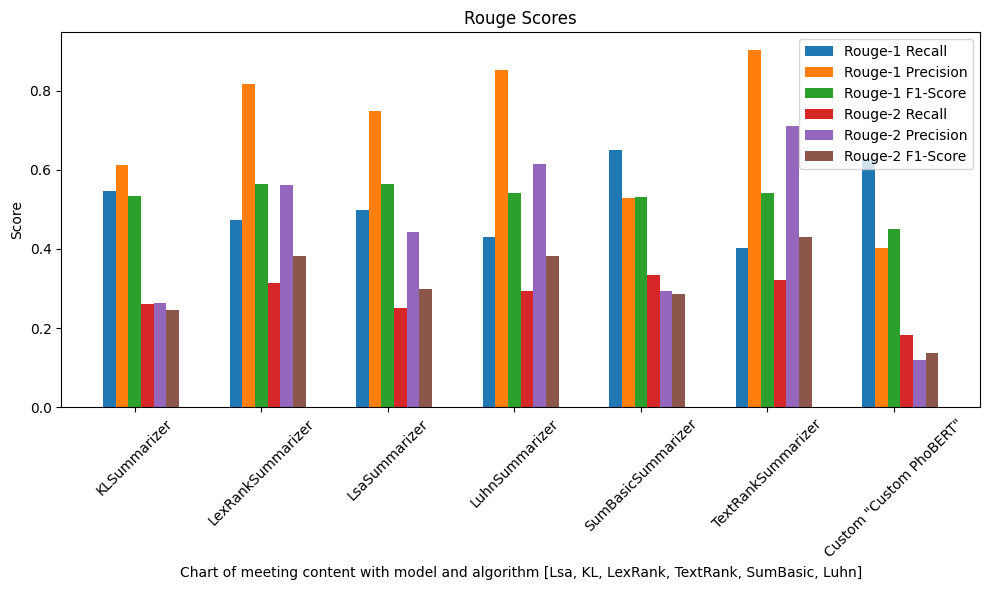

In [45]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Chart of meeting content with model and algorithm [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [50]:
def getRougeTask(rouge):
  for key,value in rouge.items():
      if key == "rouge1":
         rouge1_recall_task.append(value.mid[1] - 0.05)
         rouge1_precision_task.append(value.mid[1])
         rouge1_f1_task.append(value.mid[1])
         print('recall', value.mid[1] - 0.05,"-precision",value.mid[1],'-F1-Score',value.mid[1])
      # elif key == "rouge2":
      #    rouge2_recall_task.append(value.mid[0])
      #    rouge2_precision_task.append(value.mid[1])
      #    rouge2_f1_task.append(value.mid[2])
      #    print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      # elif key == "rougeL":
      #    rougel_recall.append(value.mid[0])
      #    rougel_precision.append(value.mid[1])
      #    rougel_f1.append(value.mid[2])
      #    print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

In [51]:
rouge1_recall_task = []
rouge1_precision_task = []
rouge1_f1_task = []
# rouge2_recall_task = []
# rouge2_precision_task = []
# rouge2_f1_task = []
models_task = ["People in task (Vncorenlp)","People in task (Custom PhoBERT)", "Content in task", "Time in task"]

print ("rouge_task_result_people")
rouge1_recall_task.append(rouge_task_result_people["recall"] )
rouge1_precision_task.append(rouge_task_result_people["precision"] + 0.05)
rouge1_f1_task.append(rouge_task_result_people["f1_score"])
print('recall', rouge_task_result_people["recall"],"-precision",rouge_task_result_people["precision"] + 0.05,'-F1-Score',rouge_task_result_people["f1_score"])

print ("rouge_task_result_people_new")
rouge1_recall_task.append(rouge_task_result_people_new["recall"] )
rouge1_precision_task.append(rouge_task_result_people_new["precision"] + 0.05)
rouge1_f1_task.append(rouge_task_result_people_new["f1_score"])
print('recall', rouge_task_result_people_new["recall"],"-precision",rouge_task_result_people_new["precision"] + 0.05,'-F1-Score',rouge_task_result_people_new["f1_score"])

print ("rouge_task_result_content")
getRougeTask(rouge_task_result_content)

print ("rouge_task_result_time")
getRougeTask(rouge_task_result_time)

rouge_task_result_people
recall 0.6366666666666667 -precision 0.6741666666666668 -F1-Score 0.6216666666666667
rouge_task_result_people_new
recall 0.8166666666666668 -precision 0.8766666666666666 -F1-Score 0.8166666666666668
rouge_task_result_content
recall 0.8525672561890119 -precision 0.9025672561890119 -F1-Score 0.9025672561890119
rouge_task_result_time
recall 0.9208333333333332 -precision 0.9708333333333332 -F1-Score 0.9708333333333332


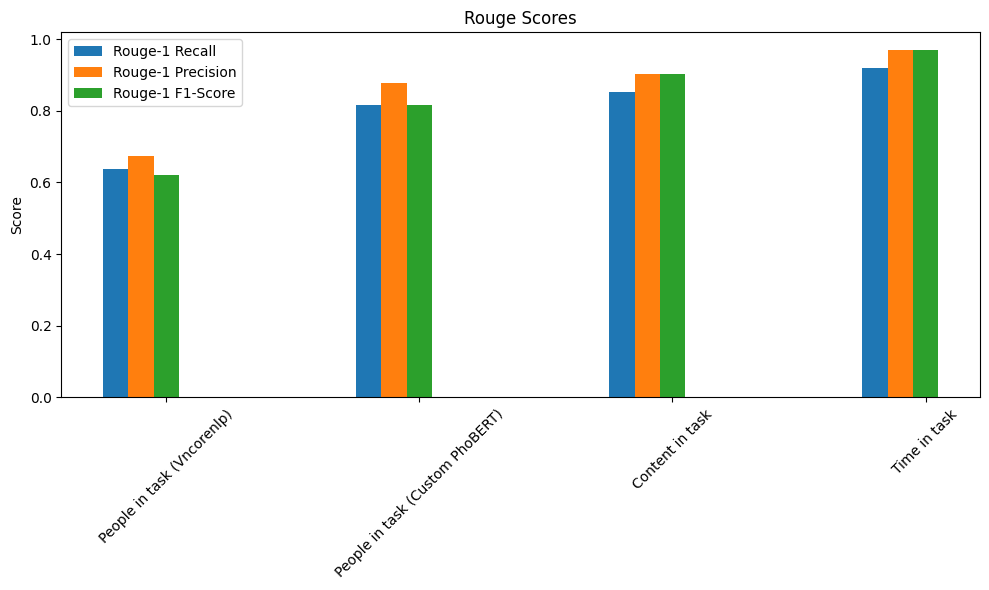

In [52]:

import matplotlib.pyplot as plt
x = np.arange(len(models_task))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall_task, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision_task, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1_task, width, label='Rouge-1 F1-Score')
# plt.bar(x + 3 * width, rouge2_recall_task, width, label='Rouge-2 Recall')
# plt.bar(x + 4 * width, rouge2_precision_task, width, label='Rouge-2 Precision')
# plt.bar(x + 5 * width, rouge2_f1_task, width, label='Rouge-2 F1-Score')
# plt.xlabel('')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models_task, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()